# SVI calibration
---



In [154]:
from scipy.optimize import differential_evolution, minimize
from scipy.interpolate import RectBivariateSpline

# Données de marché
maturities = np.array([0.08, 0.25, 0.5, 1.0])
strikes = np.array([80, 90, 95, 100, 105, 110, 120])
forwards = np.array([100.00184, 100.035506, 100.09955, 100.142101])

vol_matrix = np.array([
    [36.2, 24.0, 18.7, 14.4, 12.1, 13.2, 20.4],
    [27.8, 21.0, 18.1, 15.6, 13.9, 13.1, 13.8],
    [24.9, 20.0, 17.7, 15.9, 14.6, 13.8, 13.2],
    [22.9, 19.5, 18.0, 16.7, 16.1, 15.7, 14.9]
]) / 100.0

def svi_variance(k, a, b, rho, m, sigma):
    """Variance totale SVI"""
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

def calibrate_svi(strikes, vols, forward, maturity):
    """Calibre SVI pour une maturité"""
    k = np.log(strikes / forward)
    w_market = vols**2 * maturity
    
    def objective(params):
        w_model = svi_variance(k, *params)
        return np.sum((w_model - w_market)**2)
    
    constraints = [
        {'type': 'ineq', 'fun': lambda p: p[1]},
        {'type': 'ineq', 'fun': lambda p: 0.999 - abs(p[2])},
        {'type': 'ineq', 'fun': lambda p: p[4]},
        {'type': 'ineq', 'fun': lambda p: p[0] + p[1] * p[4] * np.sqrt(1 - p[2]**2)},
        {'type': 'ineq', 'fun': lambda p: 4 - p[1] * (1 + abs(p[2]))}
    ]
    
    bounds = [(0.0, 0.5), (0.01, 2.0), (-0.99, 0.99), (k.min(), k.max()), (0.01, 1.0)]
    
    result = differential_evolution(
        objective, bounds, seed=42, maxiter=1000, atol=1e-10, tol=1e-10
    )
    result = minimize(
        objective, result.x, method='SLSQP', constraints=constraints,
        options={'ftol': 1e-12, 'maxiter': 1000}
    )
    
    return result.x

# Calibration
print("="*60)
print("CALIBRATION SVI")
print("="*60)

params_list = []
for i, T in enumerate(maturities):
    params = calibrate_svi(strikes, vol_matrix[i], forwards[i], T)
    params_list.append(params)
    
    k = np.log(strikes / forwards[i])
    w_model = svi_variance(k, *params)
    vol_model = np.sqrt(w_model / T)
    rmse = np.sqrt(np.mean((vol_model - vol_matrix[i])**2))
    
    print(f"\nT = {T:.2f}: a={params[0]:.6f}, b={params[1]:.6f}, rho={params[2]:.6f}, "
          f"m={params[3]:.6f}, sigma={params[4]:.6f}")
    print(f"  RMSE = {rmse*100:.4f}%")

params_array = np.array(params_list)


CALIBRATION SVI

T = 0.08: a=-0.034181, b=0.099626, rho=0.064821, m=0.080890, sigma=0.355769
  RMSE = 0.0687%

T = 0.25: a=-0.000510, b=0.048818, rho=-0.662631, m=-0.001968, sigma=0.134401
  RMSE = 0.1269%

T = 0.50: a=0.004700, b=0.057636, rho=-0.869472, m=-0.000663, sigma=0.136929
  RMSE = 0.0174%

T = 1.00: a=0.018898, b=0.073401, rho=-0.989999, m=-0.017296, sigma=0.144066
  RMSE = 0.0904%


In [155]:
from scipy.interpolate import PchipInterpolator, interp1d

# params_array: shape (nT, 5) -> colonnes = [a, b, rho, m, sigma]
a_T     = params_array[:, 0]
b_T     = params_array[:, 1]
rho_T   = params_array[:, 2]
m_T     = params_array[:, 3]
sigma_T = params_array[:, 4]

# Interpolation en T des paramètres SVI (PCHIP = monotone / shape-preserving)
a_interp     = PchipInterpolator(maturities, a_T, extrapolate=True)
b_interp     = PchipInterpolator(maturities, b_T, extrapolate=True)
rho_interp   = PchipInterpolator(maturities, rho_T, extrapolate=True)
m_interp     = PchipInterpolator(maturities, m_T, extrapolate=True)
sigma_interp = PchipInterpolator(maturities, sigma_T, extrapolate=True)

# Interpolation en T des forwards
forward_interp = interp1d(
    maturities, forwards,
    kind="linear", fill_value="extrapolate", assume_sorted=True
)

T_grid = maturities        # [0.08, 0.25, 0.5, 1.0]
T0 = T_grid[0]

def svi_w_slice(u, idx):
    a, b, rho, m, sigma = params_array[idx]
    return svi_variance(u, a, b, rho, m, sigma)


def implied_vol(T, K):

    T = np.maximum(1e-8, T)
    T = np.asarray(T, dtype=float)
    K = np.asarray(K, dtype=float)

    T_flat = T.ravel()
    K_flat = K.ravel()
    vol_flat = np.empty_like(T_flat)

    T_min = T_grid[0]
    T_max = T_grid[-1]

    for n, (t, k_abs) in enumerate(zip(T_flat, K_flat)):

        # ---------- T <= T_min : short-end "flat vol" ----------
        if t <= T_min:
            # on prend la variance totale à T0 puis on la scale ~ T
            F_T0 = np.interp(T0, T_grid, forwards)
            u0   = np.log(k_abs / F_T0)

            w0 = svi_w_slice(u0, 0)          # w(T0, u0)
            w_t = w0 * (t / T0)              # variance ~ T

            t_eff = max(t, 1e-8)             # pour T=0
            w_t = max(w_t, 0.0)
            vol_flat[n] = np.sqrt(w_t / t_eff)
            continue

        # ---------- T >= T_max : on clippe à la dernière slice ----------
        if t >= T_max:
            t_eff = T_max
            F_eff = np.interp(t_eff, T_grid, forwards)
            u = np.log(k_abs / F_eff)
            w = svi_w_slice(u, len(T_grid) - 1)
            w = max(w, 0.0)
            vol_flat[n] = np.sqrt(w / t_eff)
            continue

        # ---------- T entre deux maturités : interpolation linéaire en w ----------
        i = np.searchsorted(T_grid, t) - 1
        Ti, Tip1 = T_grid[i], T_grid[i+1]

        F_t = np.interp(t, T_grid, forwards)
        u   = np.log(k_abs / F_t)

        w_i   = svi_w_slice(u, i)
        w_ip1 = svi_w_slice(u, i+1)

        w_t = ((Tip1 - t) * w_i + (t - Ti) * w_ip1) / (Tip1 - Ti)
        w_t = max(w_t, 0.0)

        vol_flat[n] = np.sqrt(w_t / t)

    return vol_flat.reshape(T.shape)



GÉNÉRATION DES GRAPHIQUES


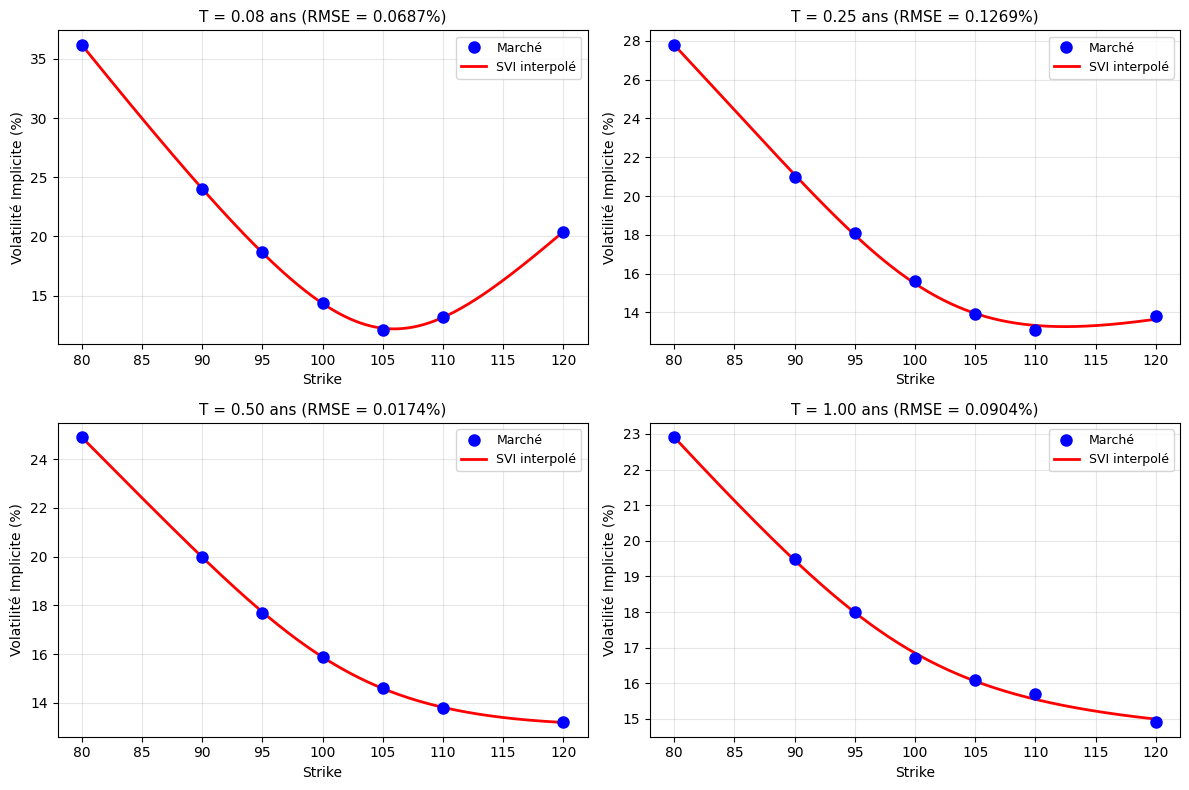

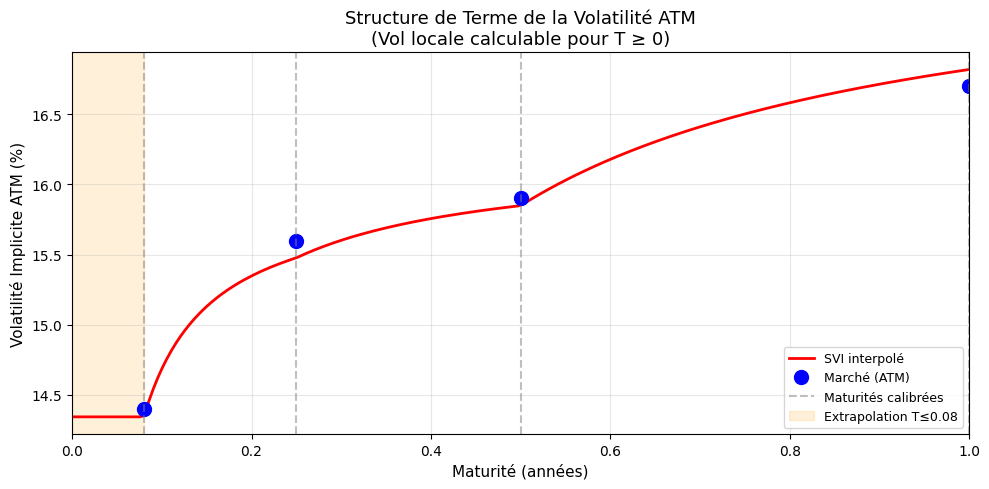

In [156]:

# Graphiques de vérification
print("\n" + "="*60)
print("GÉNÉRATION DES GRAPHIQUES")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, T in enumerate(maturities):
    ax = axes[i]
    
    # Points de marché
    ax.plot(strikes, vol_matrix[i] * 100, 'o', markersize=8, 
            label='Marché', color='blue', zorder=3)
    
    # Courbe interpolée
    K_fine = np.linspace(strikes.min(), strikes.max(), 200)
    vol_fine = implied_vol(T * np.ones_like(K_fine), K_fine) * 100
    ax.plot(K_fine, vol_fine, '-', linewidth=2, label='SVI interpolé', color='red')
    
    # Calcul RMSE
    vol_calib = implied_vol(T * np.ones_like(strikes), strikes)
    rmse = np.sqrt(np.mean((vol_calib - vol_matrix[i])**2))
    
    ax.set_xlabel('Strike', fontsize=10)
    ax.set_ylabel('Volatilité Implicite (%)', fontsize=10)
    ax.set_title(f'T = {T:.2f} ans (RMSE = {rmse*100:.4f}%)', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

# Graphique de la structure de terme ATM
fig2, ax = plt.subplots(figsize=(10, 5))

T_fine = np.linspace(0.00, 1.0, 200)
F_fine = np.interp(T_fine, maturities, forwards)        # <<< ATM = F(T)
vol_atm = implied_vol(T_fine, F_fine) * 100

# Points de marché ATM (déjà bon)
vol_market_atm = []
for i, T in enumerate(maturities):
    F = forwards[i]
    idx_atm = np.argmin(np.abs(strikes - F))
    vol_market_atm.append(vol_matrix[i, idx_atm] * 100)

ax.plot(T_fine, vol_atm, '-', linewidth=2, label='SVI interpolé', color='red')
ax.plot(maturities, vol_market_atm, 'o', markersize=10, label='Marché (ATM)', color='blue')

ax.axvline(maturities[0], color='gray', linestyle='--', alpha=0.5, label='Maturités calibrées')
for T in maturities[1:]:
    ax.axvline(T, color='gray', linestyle='--', alpha=0.5)

# Zone d'extrapolation
ax.axvspan(0, maturities[0], alpha=0.15, color='orange', label=f'Extrapolation T≤{maturities[0]:.2f}')

ax.set_xlabel('Maturité (années)', fontsize=11)
ax.set_ylabel('Volatilité Implicite ATM (%)', fontsize=11)
ax.set_title('Structure de Terme de la Volatilité ATM\n(Vol locale calculable pour T ≥ 0)', fontsize=13)
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1.0)

plt.tight_layout()
plt.show()
plt.close()